# <center>Planar Flow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_unnormalized_densities import *
from utils.training_vae import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Planar Flows**
\begin{equation*}
    z'=z+uh(w^Tz+b)
\end{equation*}
with h a piecewise non linearity (e.g. tanh).

The Jacobian is then:
\begin{align*}
    J_T(z) = I+h'(w^Tz+b)uw^T
\end{align*}
Then, the determinant of the Jacobian is:
\begin{align*}
    \det J_T(z) &= \det(I+h'(w^Tz+b)uw^T) \\
    &= \det(1+h'(w^Tz+b)w^Tu) \text{ by the matrix determinant lemma: }\det(A+VW^T)=\det(I+W^TA^{-1}V)\det(A)
\end{align*}


Problem: invertible only if $w^Tu>-1$. and no closed-form solution (can't be trained as usual).
To train it, we  normalize here the reverse KL-divergence for with we have to be able to evaluate the target density:

\begin{equation*}
    \min\limits_\theta KL((T_\theta)_\# p_Z||p_X^*)
\end{equation*}

and we have:
\begin{align*}
    KL((T_\theta)_\# p_Z||p_X^*) &= \mathbb{E}_{p_Z}[\log p_Z(z) - \log|\det J_T(z)|-\log p_X^*(T(z))]
\end{align*}

We can approximate it by Monte-Carlo if we can evaluate $p_X^*$.


## Unnormalized 2D densities

Target: $p(z)\propto e^{-U(z)}$

(https://arxiv.org/pdf/1505.05770.pdf)

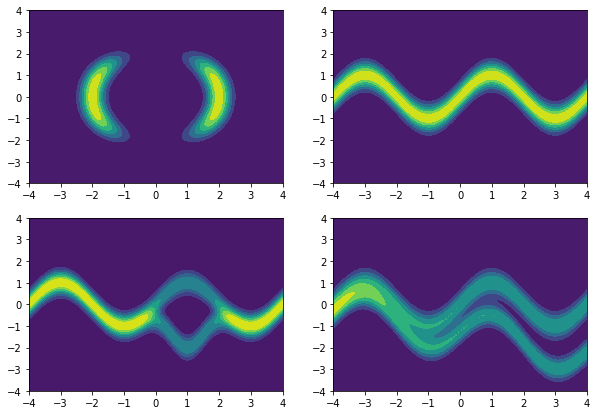

In [3]:
xline = np.linspace(-4, 4, 100)
yline = np.linspace(-4, 4, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

zz = np.exp(-U1(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid1 = zz.reshape(100,100)

zz = np.exp(-U2(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid2 = zz.reshape(100,100)

zz = np.exp(-U3(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid3 = zz.reshape(100,100)

zz = np.exp(-U4(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid4 = zz.reshape(100,100)

fig,ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].contourf(xgrid, ygrid, zgrid1)
ax[0,1].contourf(xgrid, ygrid, zgrid2)
ax[1,0].contourf(xgrid, ygrid, zgrid3)
ax[1,1].contourf(xgrid, ygrid, zgrid4)
plt.show()

### $U_1$

In [4]:
planarFlows = [PlanarFlow(2) for k in range(32)]
model = NormalizingFlows(planarFlows)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  160


In [5]:
train_loss = train_shapes(model, optimizer, U=U1p, n_epochs=1000)

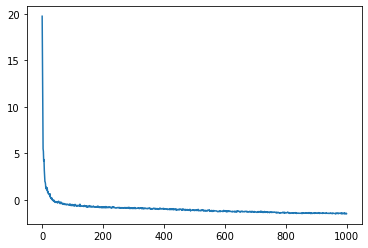

In [6]:
plt.plot(train_loss)
plt.show()

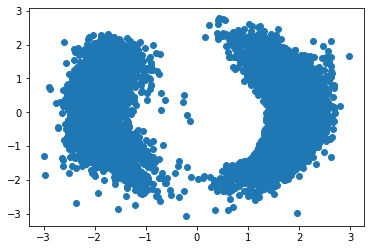

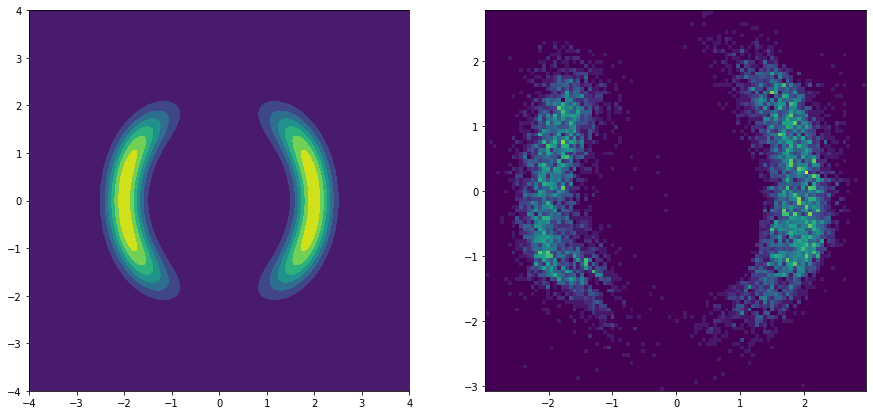

In [7]:
z,_ = model(torch.randn(10000,2,device=device))
samples = z[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid1)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
plt.show()

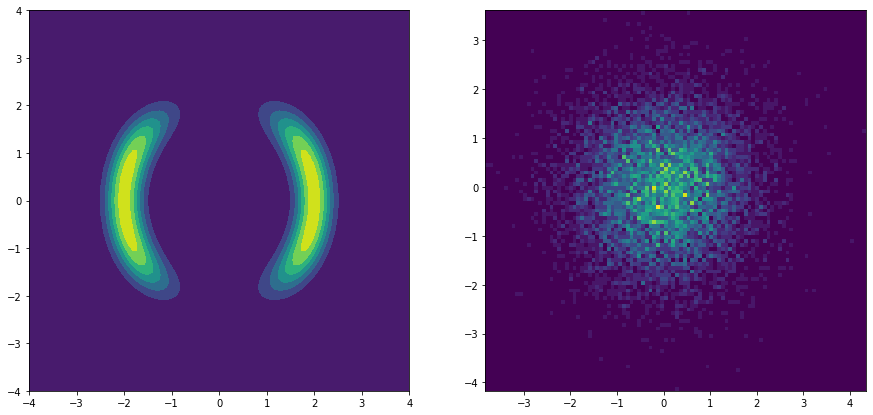

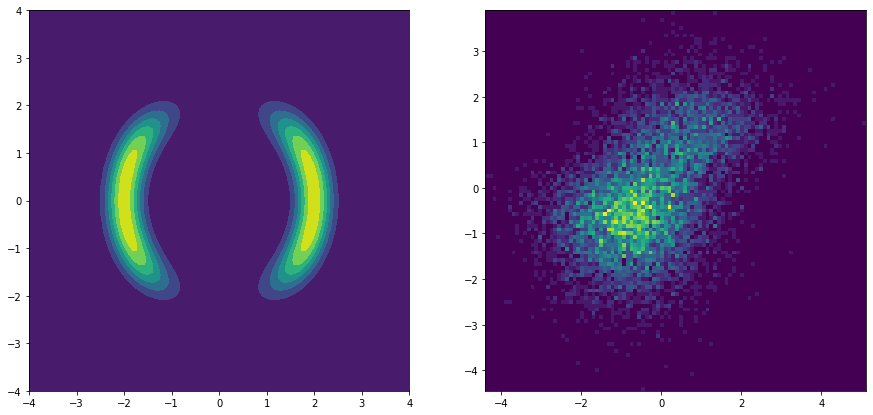

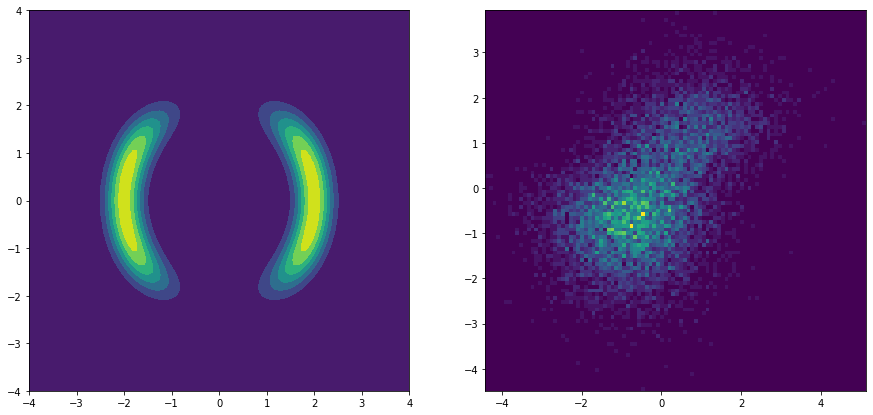

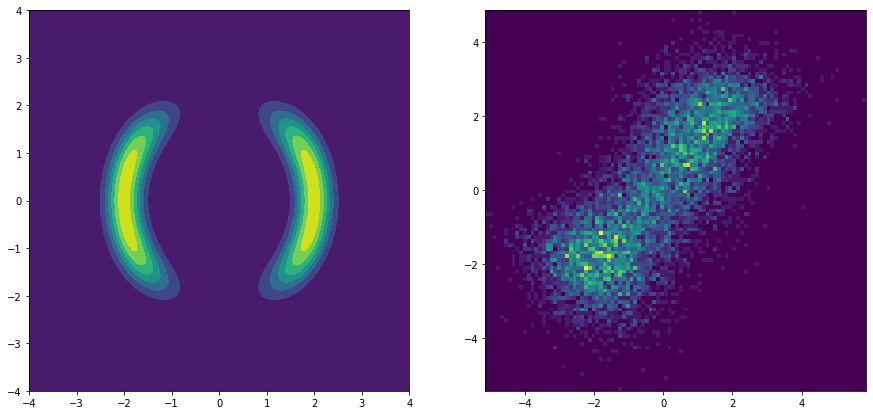

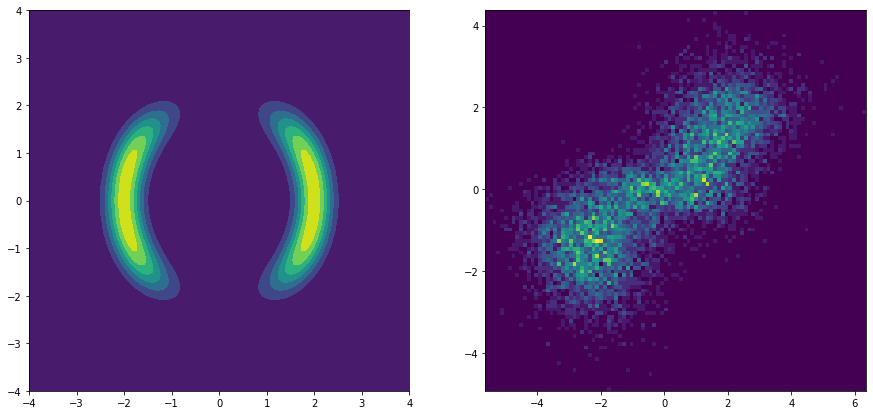

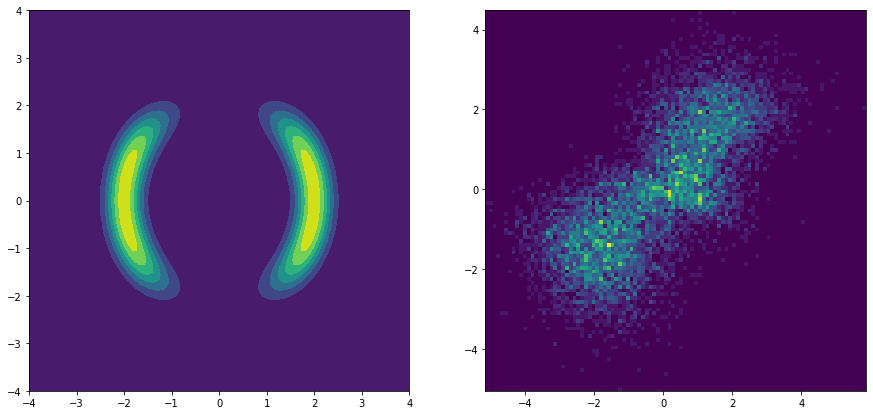

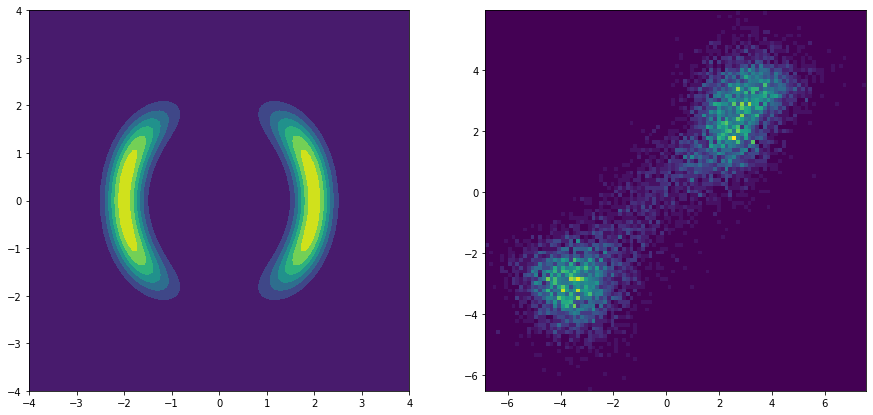

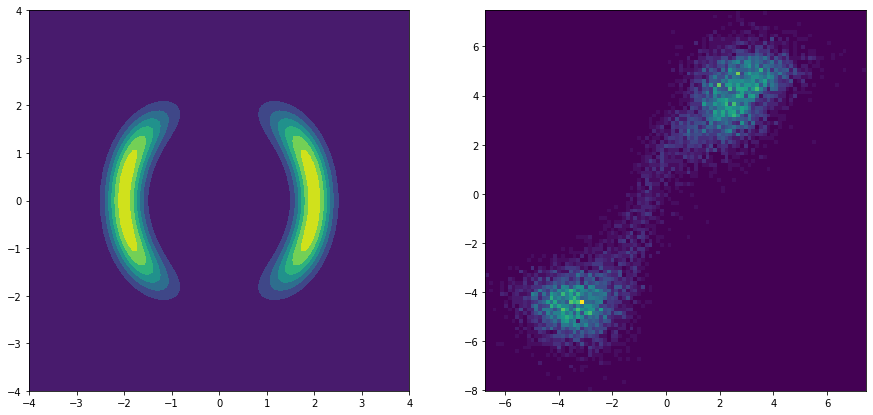

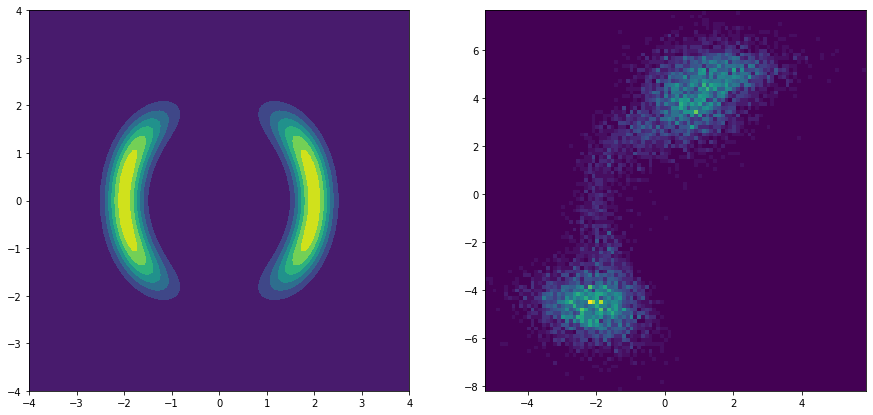

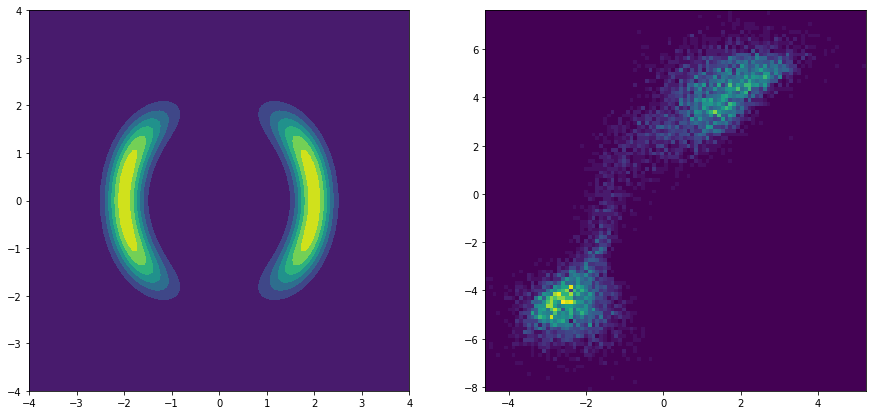

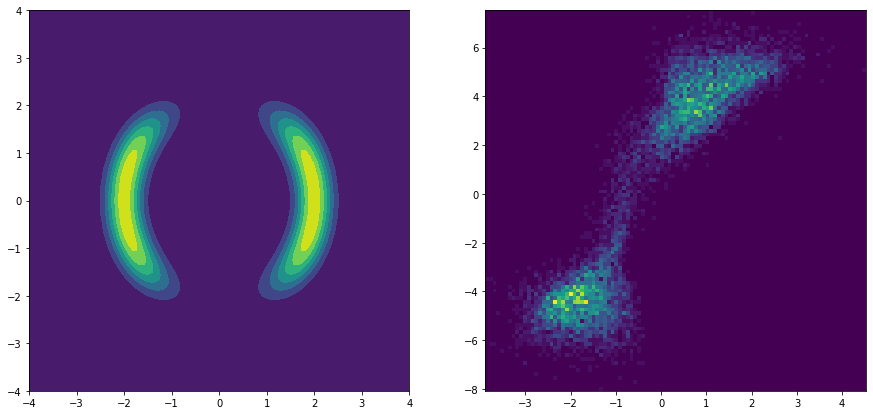

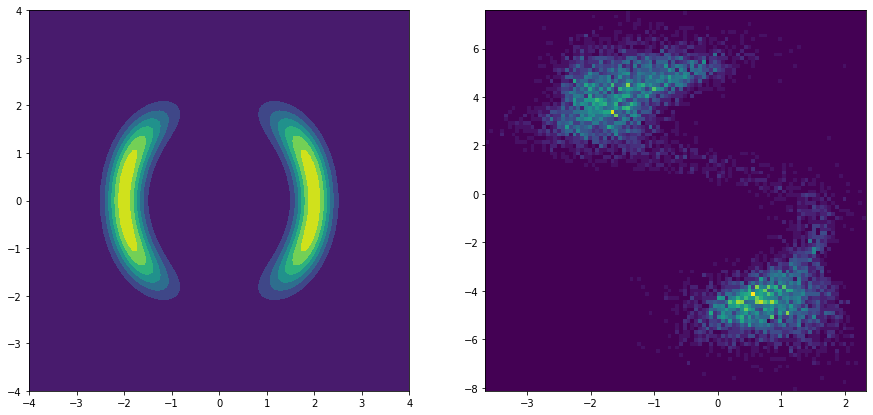

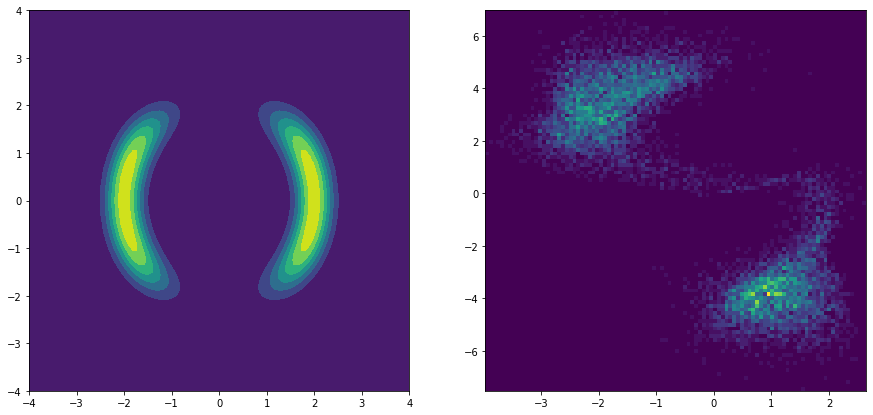

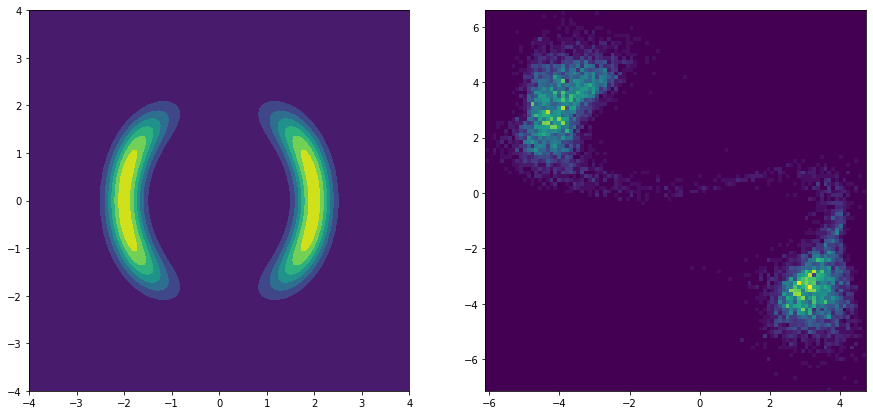

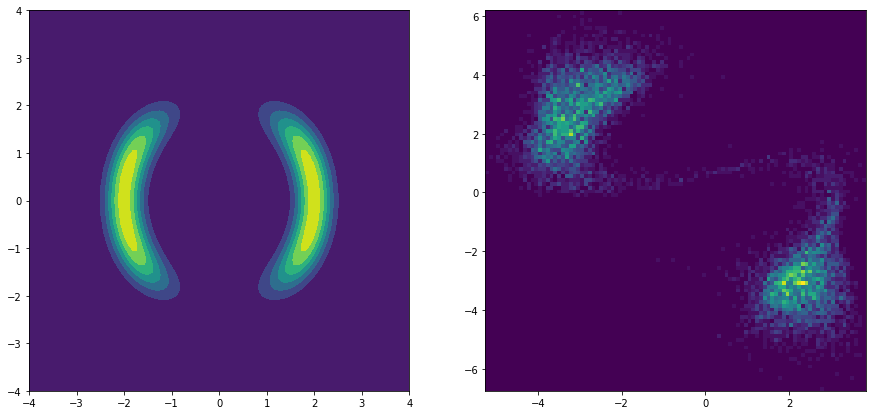

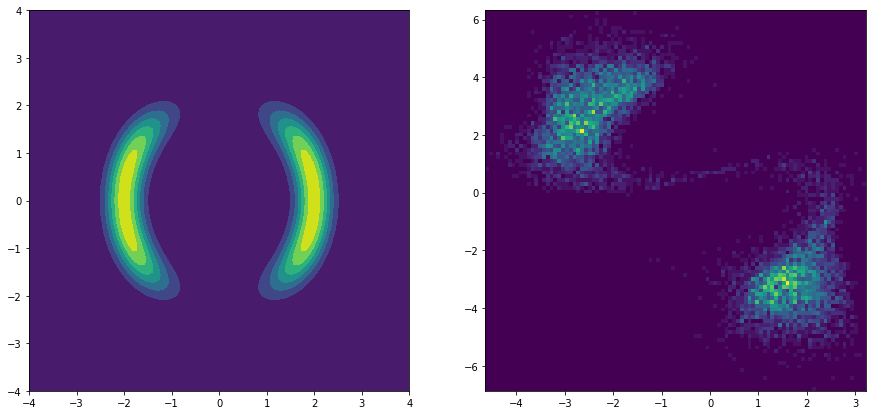

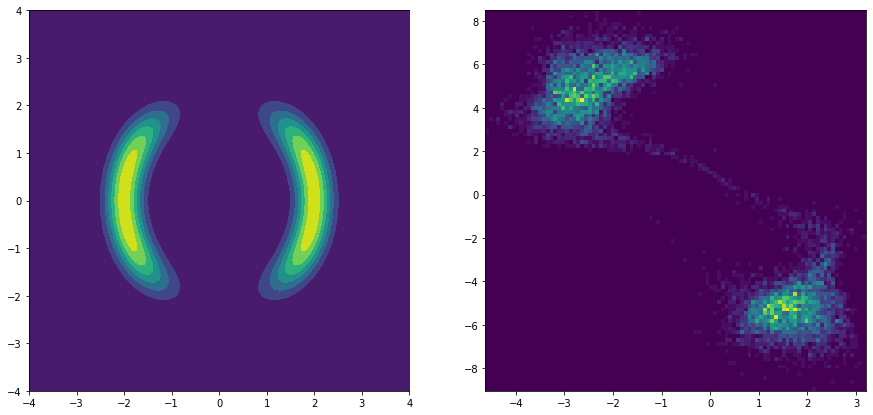

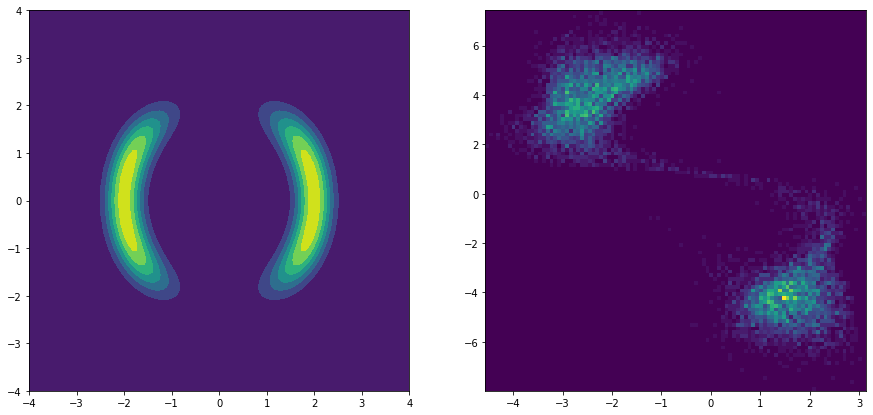

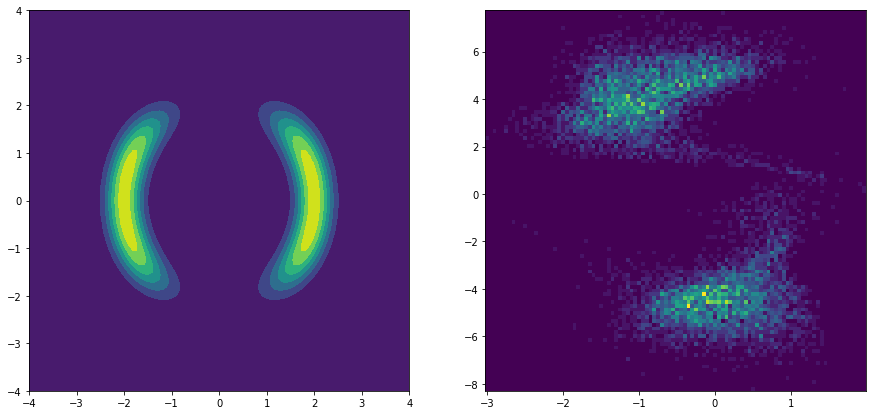

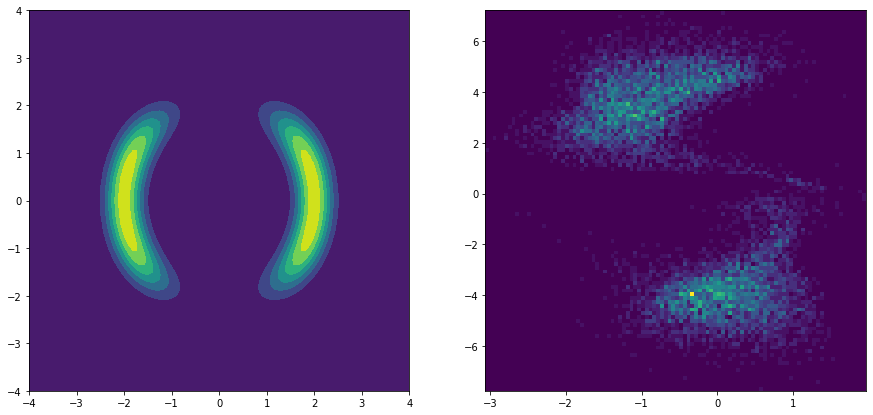

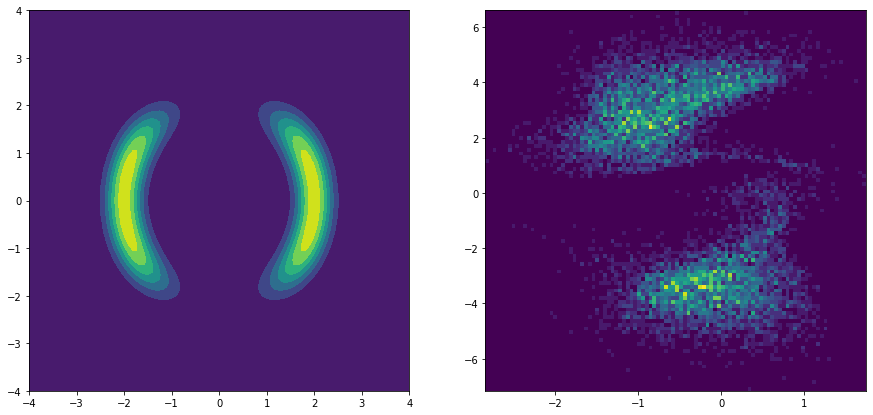

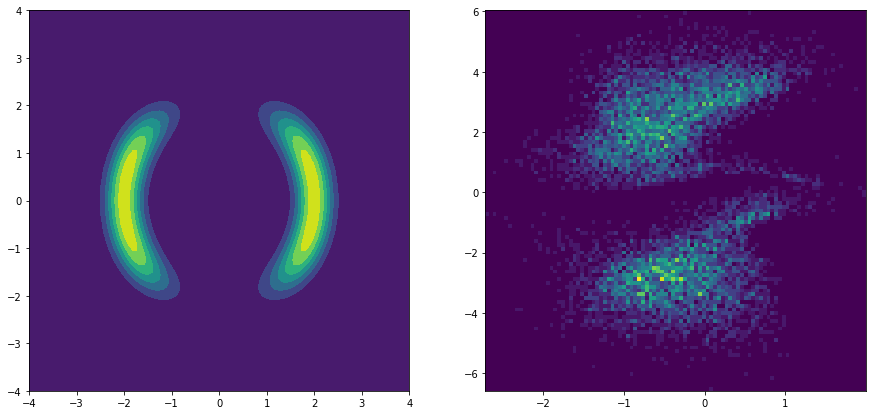

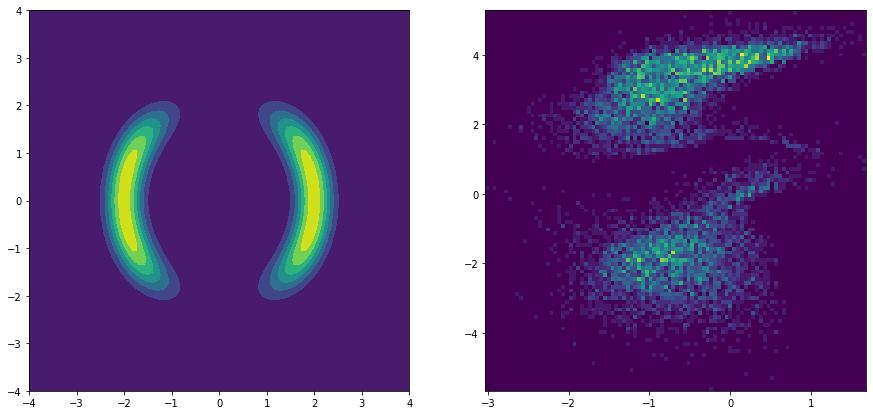

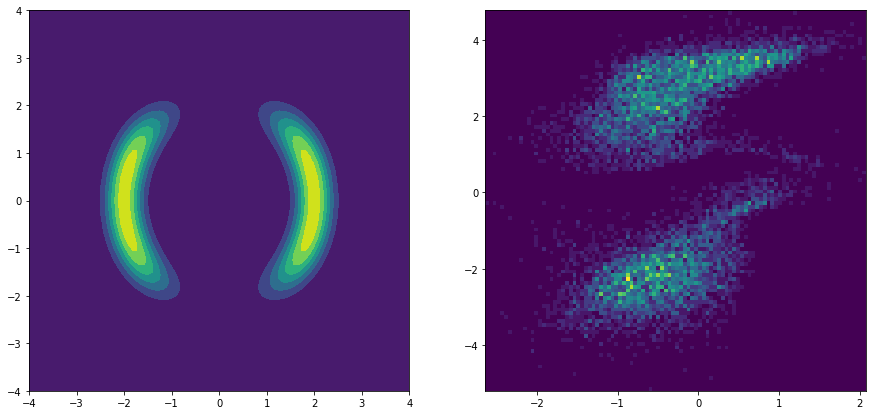

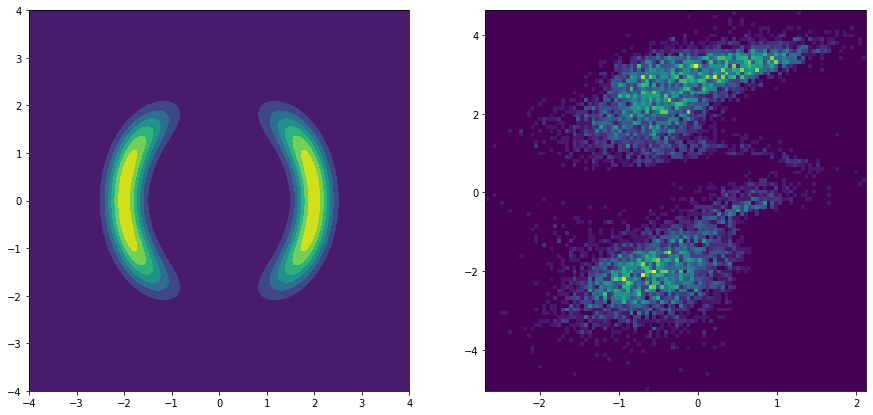

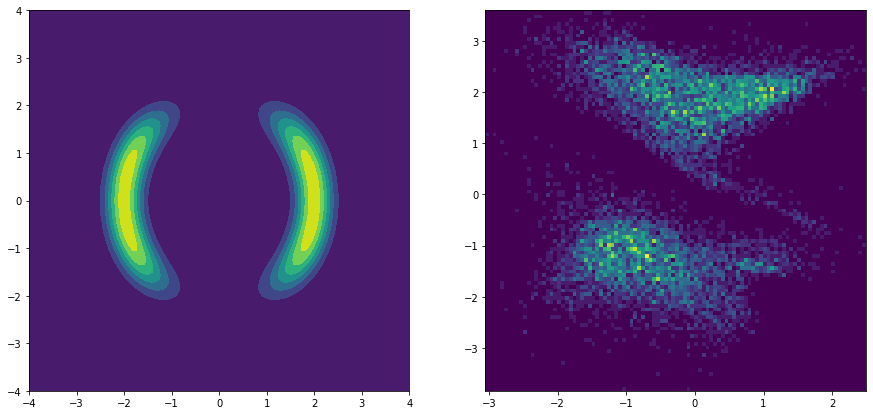

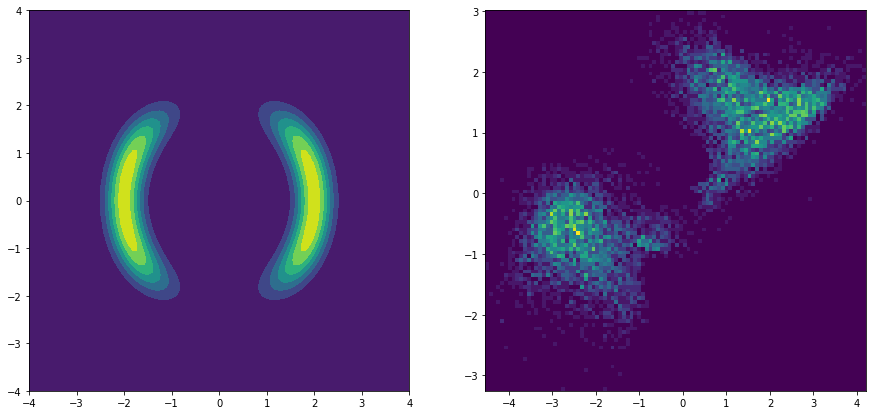

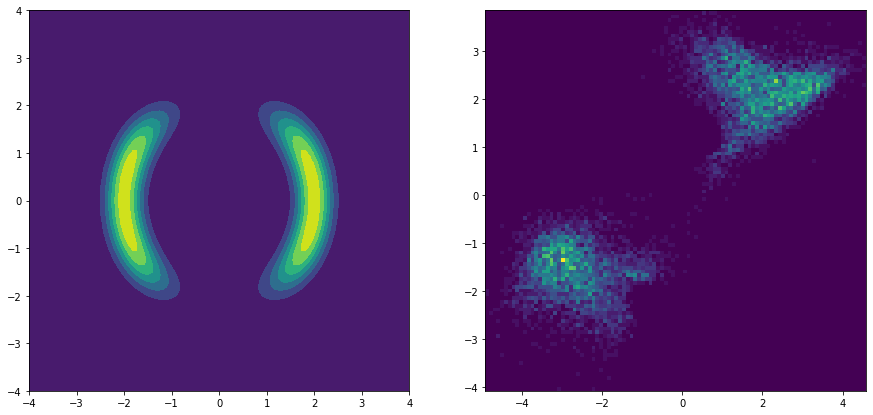

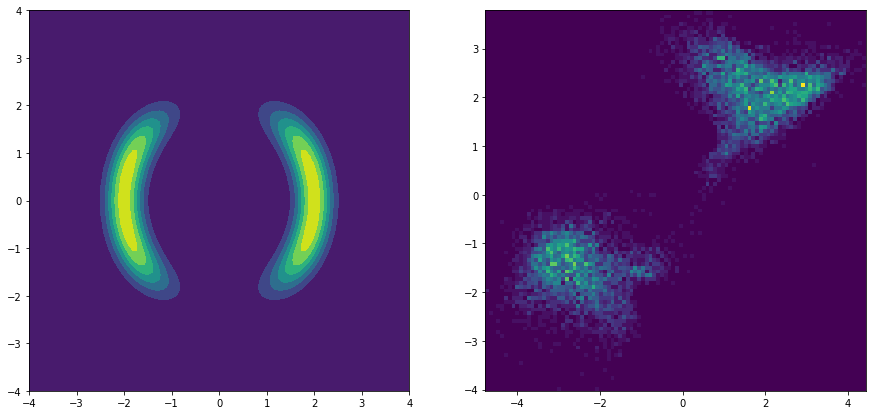

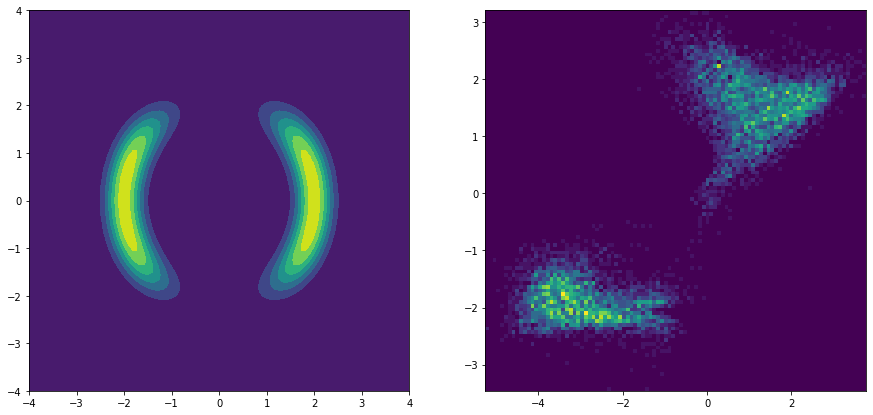

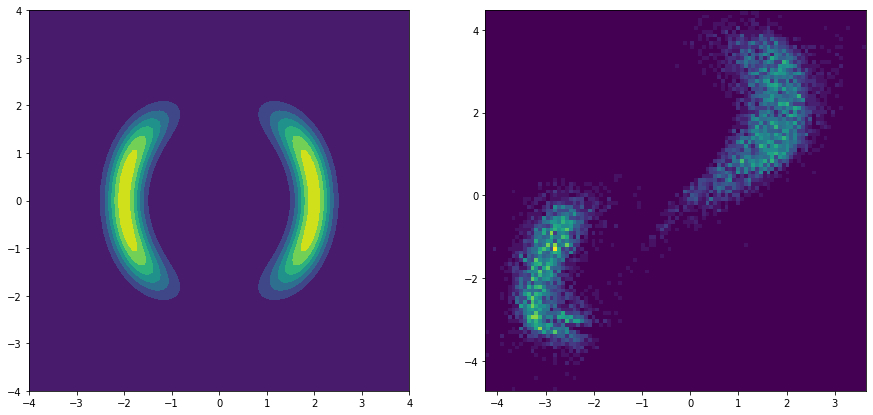

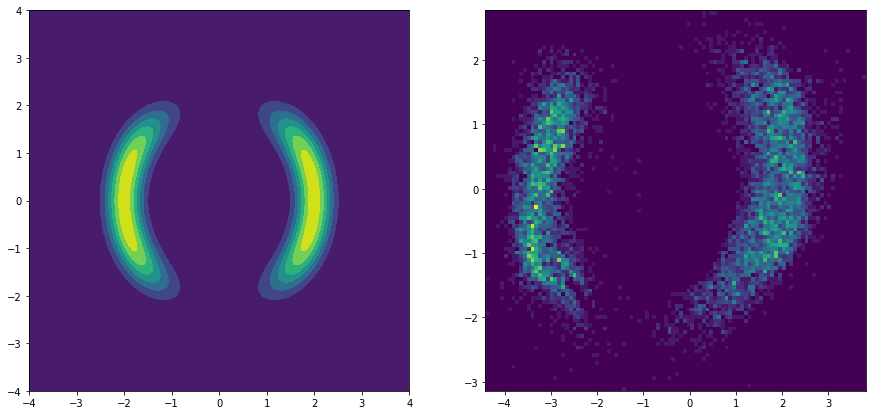

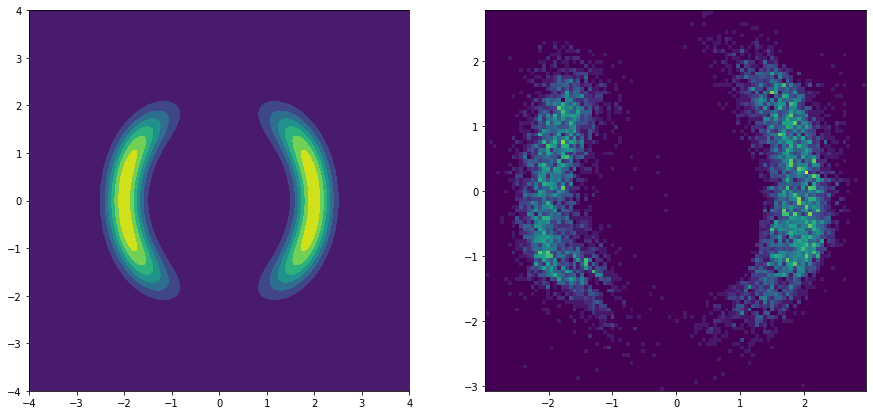

In [8]:
for i in range(len(z)):
    sample = z[i].detach().cpu().numpy()
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    ax[0].contourf(xgrid, ygrid, zgrid1)
    ax[1].hist2d(sample[:,0],sample[:,1],bins=100)
    plt.show()

### $U_2$

In [9]:
planarFlows = [PlanarFlow(2) for k in range(32)]
model = NormalizingFlows(planarFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
train_loss = train_shapes(model, optimizer, U=U2p, n_epochs=10001)

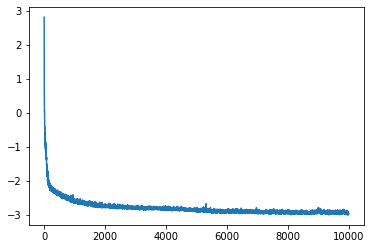

In [11]:
plt.plot(train_loss)
plt.show()

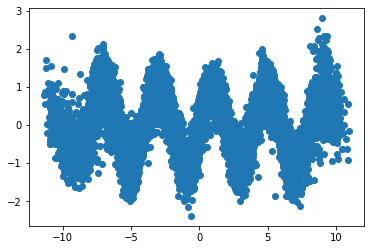

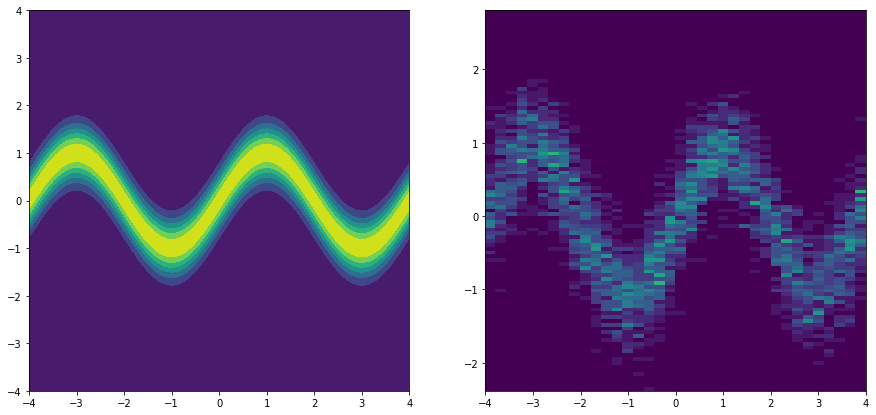

In [14]:
samples,_ = model(torch.randn(10000,2,device=device))
samples = samples[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid2)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
ax[1].set_xlim(-4,4)
plt.show()

## Variational Encoder with NF

ELBO:
We have:
\begin{align*}
    \log p_\theta(x)&\geq \log p_\theta(x)-KL(q(\cdot|x)||p_\theta(\cdot|x))\\
    &= \int \log(\frac{p_\theta(x,z)}{q(z|x)})q(z|x)dz \\
    &= \mathbb{E}_{q(\cdot|x)}[p_\theta(x|z)]-KL(q(\cdot|x)||p_\theta) \\
    &= -\mathcal{F}(\theta)
\end{align*}

**Variational Encoder**:
- encoder: $q_\phi(z|x)$
- decoder: $p_\theta(x|z)$

Example for classical VAE:
- encoder: $q_\phi(z|x)=\mathcal{N}(z;\mu,\sigma^2 I)$
- apriori: $p_\theta(z)=\mathcal{N}(z;0,I)$
- decoder: $p_\theta(x|z)=\mathcal{N}(x;\mu(z),\sigma^2(z))$ or $p_\theta(x|z)=\text{Ber}(D(z))$

**VAE with NF**: 

Idea: improve the class of distribution for the variational inference with a normalizing flow in the latent space (e.g. not just a mean field approximation with gaussians anymore).

- $q_0(z|x)=\mathcal{N}(z;\mu(x),\sigma^2(x))$

Let $z_0\sim q_0(\cdot|x)$,

- $z_K = f_K\circ\dots\circ f_1(z_0) = f(z_0)$
- $q_K(z_K|x) = q_0(z_0|x)|\det J_f(f^{-1}(z_K))|^{-1}$
- $\log q_K(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|$

Then, denoting $q_\phi=q_K$, the ELBO transforms as:

\begin{align*}
    \mathcal{F}(\theta,\phi) &= \mathbb{E}_{q_\phi}[\log q_\phi(z|x)-\log p_\theta(x,z)] \\
    &= \mathbb{E}_{q_0}[\log q_0(z_0|x)-\log p_\theta(x,f(z_0))-\sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|]
\end{align*}

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

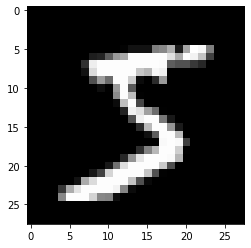

In [4]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [5]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)
    
    
class VAE(nn.Module):
    def __init__(self,flow,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
        self.flow = flow
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z0 = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        zKs, log_det = self.flow(z0)
        y = self.decoder(zKs[-1])
        return y, mu, log_sigma, log_det

In [6]:
planarFlows = [PlanarFlow(10) for k in range(2)]
flow = NormalizingFlows(planarFlows)

model = VAE(flow, d=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  820046


0 151.71027949590078 124.32345776055186


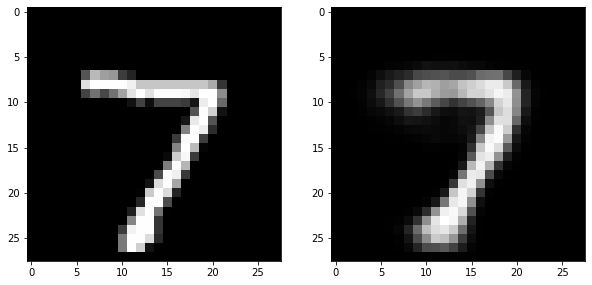

1 120.53228553170081 115.69898574877851
2 114.43148066257025 111.46328981539693
3 110.88207819111058 108.68213782752284
4 108.54442145287271 106.51914280900559
5 106.85046610123905 105.26443895821373
6 105.46146172128337 103.61758939602885
7 104.3912840831678 103.11272381669797
8 103.38278755670588 102.44150745525909
9 102.59465505658267 101.72472215841373
10 101.84200229929455 100.61538720664124
11 101.25246504273242 100.47559707690351
12 100.60242672007222 99.53982473257632
13 100.20258507528624 100.09916818637056
14 99.57235857130537 98.90968478754306
15 99.23606049429887 98.3424632404559
16 98.82538538040129 98.04480197406805
17 98.39849417007979 98.15370439035824
18 98.1408122319572 97.50780913624139
19 97.76781078628724 97.15220176526152
20 97.45910048603419 97.11555205518826
21 97.20469414467667 96.91609630645654
22 96.89767472864298 96.75581396425875
23 96.64877709210471 96.47365804068959
24 96.35787763778589 96.13850212706545
25 96.19821722251604 96.00718981465593
26 95.987511

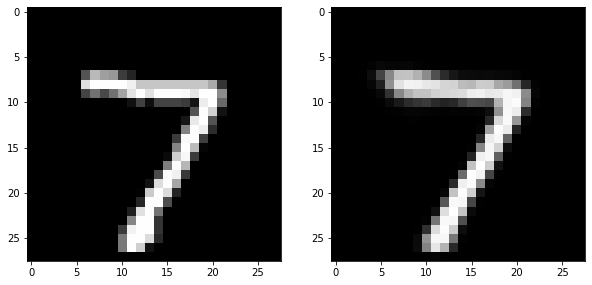

51 92.54160697085686 92.94357965243891
52 92.46211668880764 93.0787608235027
53 92.3322336865217 93.18789385225826
54 92.2834351843947 92.87920530764059
55 92.1625084568612 92.90835807727167
56 92.10376024280106 93.11748919014732
57 92.06457976101983 93.0603417588499
58 91.99682900239664 92.71228095593925
59 91.84883964663291 92.82521125379081
60 91.81869009596791 92.5814433966201
61 91.74810218946595 92.9417981278782
62 91.69547923507636 92.82849016280981
63 91.6023298424868 93.36247857919517
64 91.54065297119314 92.8674258637352
65 91.51471705867114 93.05147223426891
66 91.45134807226076 92.61936809308231
67 91.33753443475979 92.5612914844062
68 91.32072385829987 92.22555873493036
69 91.2400927133567 92.37925118150802
70 91.22386669383967 92.22185443232235
71 91.13729226682402 92.25368780069077
72 91.10850850249659 92.1403682818428
73 91.04443844142499 92.2789846060756
74 90.99259851126274 92.35962014000256
75 90.87985796681006 92.21962455286385
76 90.90599492228277 92.20909028464612

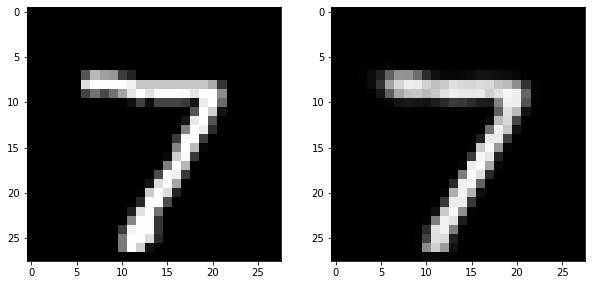

101 89.93469548445691 91.5078663688879
102 89.86490874571757 91.6574110573473
103 89.79162003355155 91.6787507419769
104 89.77871875451147 91.65362841328874
105 89.80637698522592 91.45700253617649
106 89.76225127306236 91.5214640218229
107 89.75598037166637 91.56728026661249
108 89.74163404083794 91.36035280562818
109 89.63921136591735 91.66950550018409
110 89.65943711314036 91.76231930278742
111 89.5808630362418 91.3965384388884
112 89.58066633667774 91.63698424317967
113 89.58120337122284 91.69537889766998
114 89.48146068516063 91.20707963449887
115 89.51481785669172 91.42832615276495
116 89.50232122295192 91.41843143743448
117 89.42897349278302 91.74469883830403
118 89.44035990050098 91.67836152098049
119 89.40797997469926 91.3720482774436
120 89.40991377406876 91.33615831369028
121 89.32910344409197 91.35124506356236
122 89.27876211246364 91.33896780775758
123 89.28541291107418 91.2475580087485
124 89.25477683061222 91.29141483977199
125 89.18196573372673 91.49214113863131
126 89.2

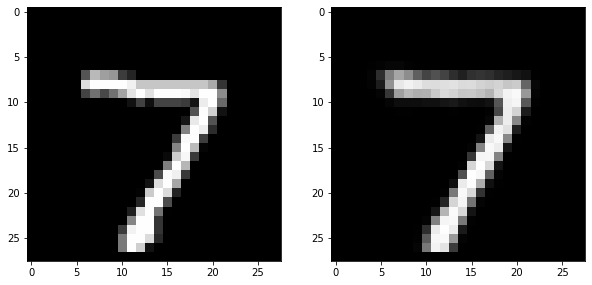

151 88.72165851823472 91.24916193660455
152 88.62270171403377 90.71157778413912
153 88.65420269779729 91.34554880647994
154 88.64404655841538 90.95662177332675
155 88.60046123187425 91.14754983335257
156 88.61323659608105 91.08236011834191
157 88.58871914904933 91.22128403148712
158 88.5784926533106 90.77012436839338
159 88.5879942535422 91.41450975801997
160 88.53720936507474 91.25055282641523
161 88.44088896403689 91.28295981312712
162 88.56083454709571 91.26495368640644
163 88.42420254553475 90.9122520666153
164 88.45962874162426 90.91845888375474
165 88.41942715729562 91.19271955398706
166 88.41819654192243 90.9450409374298
167 88.43764453012213 91.36512568659676
168 88.41326184194818 90.92264564197285
169 88.36064060105444 90.86196355850171
170 88.3630332214746 90.9984932798928
171 88.34802603975797 90.76841726089819
172 88.30999497208259 91.00239538613219
173 88.26719466523237 90.97226464024747
174 88.26110258014302 90.89578924697047
175 88.26308362536508 91.32158960701939
176 88

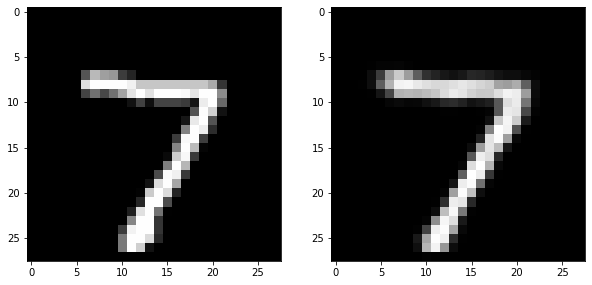

In [ ]:
train_losses, val_losses = train_vae(model, optimizer, train_loader, test_loader=test_loader)

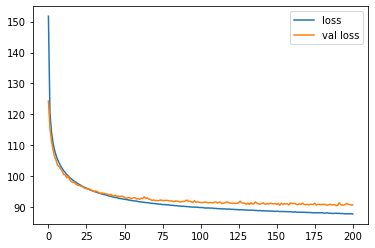

In [ ]:
plt.plot(train_losses,label="train loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:
- Log Likelihood estimation

## References

<a id="reference1"></a>

[1] Rezende, J.R., & Mohamed, S. Variational Inderence with Normalizing Flows. arXiv preprint arXiv:1505.05770. (2016). [link](https://arxiv.org/pdf/1505.05770)